# Datasets & DataLoader
Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled from our model training code for better readability and modularity. PyTorch provides two data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as your own data. `Dataset` stores the samples and their corresponding labels, and `DataLoader` wraps an iterable around the `Dataset` to enable easy access to the samples.

为了提高代码的可读性和模块化，我们希望将数据集代码与模型训练代码**解耦**（将数据集的加载和预处理逻辑与模型训练的逻辑分离开来）。

为此，PyTorch 提供了两个关键的数据处理工具：
1. Dataset：存储数据样本及其对应的标签。
2. DataLoader：为 Dataset 提供可迭代的封装，支持批量加载和高效的数据访问。

这使得我们可以轻松地使用预加载的数据集或自定义的数据集，从而简化数据加载和管理的过程。

## Loading a Dataset
与 Quickstart 中的例子一样，加载相同的数据集 FashionMNIST

Fashion-MNIST 数据集包含的是影像数据，其中有 60,000 个训练集和 10,000个测试集，每一个样本都是由一张 28x28 像素的灰度图片以及一个标签组成。

- root="data"：数据集的存储位置，下载的文件会存放在 data/ 文件夹中。
- train=True：指定加载的是训练集。
- download=True：如果本地的 data/ 目录中不存在 FashionMNIST 数据集，则自动从互联网下载。
- transform=ToTensor()：在加载图像时，将其从PIL图像转换为PyTorch张量，并将像素值从\[0, 255\]缩放到\[0, 1\]。

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root = '/work/Quickstart/data',
    train = True,
    download = False,
    transform = ToTensor()
)

test_data = datasets.FashionMNIST(
    root = '/work/Quickstart/data',
    train = False,
    download = False,
    transform = ToTensor()
)

## Iterating and Visualizing the Dataset
为 Dataset 手动设置索引

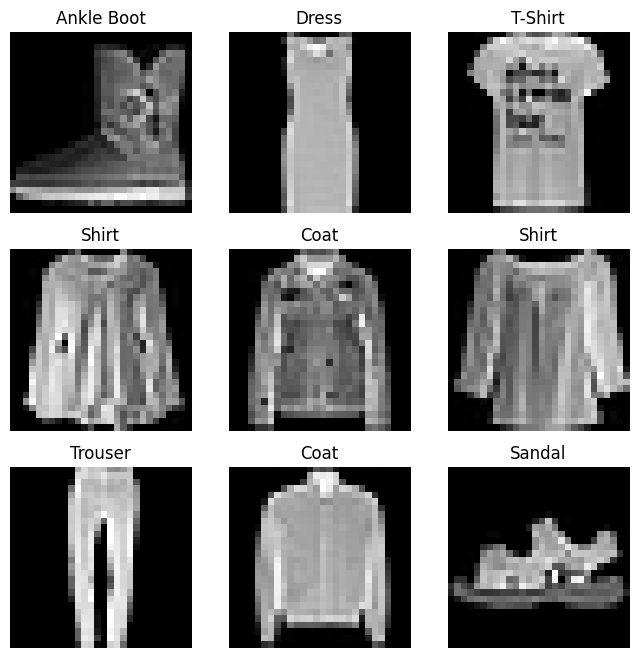

In [2]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1): # 取 3*3=9 个样本，用于可视化
    sample_idx = torch.randint(len(training_data), size=(1,)).item() # 随机取一个训练样本
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

---
## Creating a Custom Dataset for your files
A custom Dataset class must implement three functions: _\_\_init\_\__, _\_\_len\_\__, and _\_\_getitem\_\__. Take a look at this implementation; the FashionMNIST images are stored in a directory `img_dir`, and their labels are stored separately in a CSV file `annotations_file`.

自定义 Dataset 类必须具有 3 个函数 _\_\_init\_\__, _\_\_len\_\__ 和 _\_\_getitem\_\__

1. 自定义的类要继承 `Dataset` 才行，因为 `DataLoader` 要求传入的对象必须是 `Dataset` 的子类
2. 子类中需要定义`__self__` 属性，因为在 `Dataset` 这个抽象类中是没有定义`__self__`的，也因此不用使用`super().__init__()`来调用父类的属性
3. 在子类中定义 `__len__`的方法，是因为希望 `DataLoader` 计算 `epoch` 数。在 `Dataset` 这个抽象类中是没有`__len__`这个方法的，原因是，有些数据集的大小可能是未知的，例如流式数据集，所以并不会强制要求 `__len__`的存在。
4. 在子类中定义 `__getitem__`的方法，是因为每次调用的时候，返回一条数据的特征和标签。虽然在父类中也定义了`__getitem__`的方法，但是父类中的这个方法是抽象方法，无法直接使用，就需要子类重写`__getitem__`方法

In [3]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset): # 继承 Dataset 的自定义类，专门用于从文件目录中加载图像和标签
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file) # 存储图像名称和标签
        self.img_dir = img_dir # 图像所在目录
        self.transform = transform # 图像的变换函数
        self.target_transform = target_transform # 标签的变换函数

    def __len__(self):
        return len(self.img_labels) # 返回数据集的大小

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0]) # 获取图像路径
        image = read_image(img_path) # 读取图像，转换为张量 (C, H, W)
        label = self.img_labels.iloc[idx, 1] # 获取 csv 中的标签
        if self.transform:
            image = self.transform(image) # 如果定义了图像变换，则进行变换
        if self.target_transform:
            label = self.target_transform(label) # 如果定义了标签变换，则进行变换
        return image, label

---
## Preparing your data for training with DataLoader

In [4]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size = 64, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = 64, shuffle = True)

## Iterate through the DataLoader


- DataLoader 是一个可迭代对象，`iter()` 将 `DataLoader` 转换为一个**迭代器对象**。
- DataLoader 每次生成一个批次的 (features, labels)对。

`next()` 从迭代器中取出第一个批次的数据 「类似于在 python 中从一个列表迭代器中获取第一个值」

因此 `train_features` 将包含第一个批次中 64 张图片，并以 `tensor` 的数据类型存储，`train_labels` 则包含第一个批次中 64 张图片对应的标签

特征批次大小: torch.Size([64, 1, 28, 28])
标签批次大小: torch.Size([64])


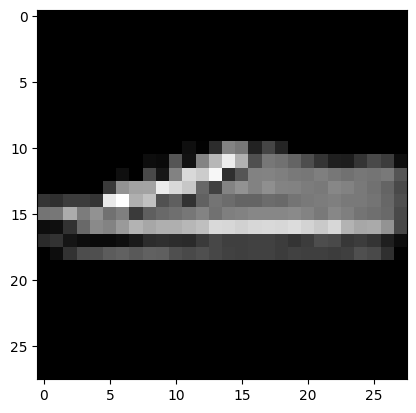

标签: 7


In [5]:
# 展示图像以及标签
train_features, train_labels = next(iter(train_dataloader))
print(f'特征批次大小: {train_features.size()}')
print(f'标签批次大小: {train_labels.size()}')
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap='gray')
plt.show()
print(f'标签: {label}')